# Langgraph

## imports

### 1.StateGraph:

While building an AI app, we often need to run a sequence of steps:

1. Take user input

2. Call an LLM

3. Process the response

4. Maybe loop or branch depending on the answer

Codeing this manually can get messy with lots of if/else, state tracking, and function calls.

**StateGraph** makes this cleaner by describing app as a flowchart:

> Each node = a function (like “get user input” or “call model”).

> he edges = arrows showing what happens next.

> The state = shared memory that flows through the graph.

- ***State*** → It holds your app’s memory.
- ***Nodes*** → These are functions that read the state and return updates.
- ***Reducers*** → These are rules that say how to merge new updates into the existing state.
- ***Edges*** → Connections that control the flow.
- ***END*** → Special node meaning the flow is done.

#### rules to create a graph

- Create the graph first: ```g = StateGraph(State)```

- Add a node before you reference it
    - You must add_node("name", fn) before you:
        - set it as the entry point, or
        - create an edge from/to it.

- Set the entry point to an existing node
    ```g.set_entry_point("greet")``` only after ```"greet"``` is added.

- Add edges only between existing nodes (or to ```END```)
Both endpoints must exist (except ```END```, which is special).

- Compile last
    ```app = g.compile()``` after the whole graph is wired.


# Langchain

## langchain_core: 
- its a lightweight core package of langchain
- This reperesent different kinds of chat messages in a structured way

### 1. HumanMessage:
- Represent a message sent by the user
- it has a **content** field which is the text
- it has optional metadata
- This helps track who said what in the conversation

### 2. AnyMessage:
- In LangChain we have: 
    - **HumanMessage** &rarr; user imput
    - **AIMessage** &rarr; model's response
    - **SystemMessage** &rarr; system instructions

# Typing

### Annotated:
- it take a type like str, list, Dict etc and add a metadat to it






In [1]:
from typing import Dict, TypedDict, Annotated
from langgraph.graph import StateGraph, END, add_messages
from langchain_core.messages import AnyMessage, HumanMessage

### Example 1

In [2]:
class AgentState(TypedDict):
    message: str

def greeting_node(state: AgentState)->AgentState:
    """Node that adds a greeting message to the state"""
    state['message']="Hey "+state['message']
    return state


In [3]:
graph=StateGraph(AgentState)
graph.add_node("greeter",greeting_node)
graph.set_entry_point("greeter")
graph.add_edge("greeter", END)
app=graph.compile()

In [4]:
print(app.invoke({"message": "there!"}))

{'message': 'Hey there!'}


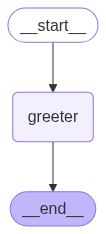

In [5]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

### Example 2

#### Steps:
- Define Class
- node function: read state &rarr; returns partial update
- Build the graph

In [6]:
# 1.) Define Class
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    turns: int

In [7]:
# 2.) node function 1
def greet(state: State) -> State:
    last_msg=state['messages'][-1].content
    return {
        "messages":[HumanMessage(content="Hey "+last_msg)],
        "turns": state.get("turns", 0) + 1
    }

In [8]:
def next_greet(state: State)->State:
    last_msg=state['messages'][-1].content
    return {
        "messages":[HumanMessage(content="Hello "+last_msg)],
        "turns": state["turns"]+1
    }

In [9]:
# 3) Build the graph
g=StateGraph(State)
g.add_node("greet", greet)
g.add_node("next_greet", next_greet)
g.set_entry_point("greet")
g.add_edge("greet", "next_greet")


#### &rarr; add_conditional_edges
```python
graph.add_conditional_edges(
    "decider",        # the node after which branching happens
    router_function,  # a function(state) -> key
    {
        "path1": "nodeA",
        "path2": "nodeB",
        END: END
    }
)
```
- where **"path1"** is the return value from router_function 
- if the value returned is **"path1"** than will go to **"nodeA"** else **"END"**

In [10]:
def turn_condition(state: State)->State:
    return "first" if state['turns']<2 else END

In [11]:
g.add_conditional_edges("next_greet", turn_condition,{"first": "greet", END:END})

In [12]:
app=g.compile()

In [15]:
result = app.invoke({"messages": [HumanMessage(content="")], "turns": 0})

In [16]:
result

{'messages': [HumanMessage(content='', additional_kwargs={}, response_metadata={}, id='5c9447a9-d5b1-4d3b-95f6-5b568db41428'),
  HumanMessage(content='Hey ', additional_kwargs={}, response_metadata={}, id='2c9c19e1-f912-4a81-931b-9cd60b47a184'),
  HumanMessage(content='Hello Hey ', additional_kwargs={}, response_metadata={}, id='6a10d3ff-5d36-4107-88b3-1dc62a2c8c83')],
 'turns': 2}

In [17]:
result2=app.invoke({
        "messages": [
            HumanMessage(content="Hey there!"),
            HumanMessage(content="How are you doing?"),
            HumanMessage(content="This is a second line in the same step."),
        ],
        "turns": 0,
    })

In [18]:
result2

{'messages': [HumanMessage(content='Hey there!', additional_kwargs={}, response_metadata={}, id='8dae51cb-2785-40dc-8052-425120056191'),
  HumanMessage(content='How are you doing?', additional_kwargs={}, response_metadata={}, id='466b34ee-99e0-44de-bbd3-dfb1b9b03efc'),
  HumanMessage(content='This is a second line in the same step.', additional_kwargs={}, response_metadata={}, id='b335584b-098b-4b89-9abd-e79cdbbc2fa5'),
  HumanMessage(content='Hey This is a second line in the same step.', additional_kwargs={}, response_metadata={}, id='d5b0828d-43e6-4f76-a005-663b0724cfad'),
  HumanMessage(content='Hello Hey This is a second line in the same step.', additional_kwargs={}, response_metadata={}, id='f3353fd2-56d5-4dea-a59f-3d64cfc783d9')],
 'turns': 2}

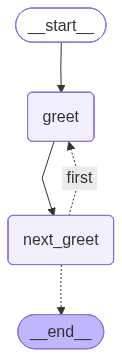

In [19]:

display(Image(app.get_graph().draw_mermaid_png()))

### Example 3

#### Personalized Compliment Agent

In [43]:
class ComplimentAgent(TypedDict):
    name:Annotated[list[AnyMessage], add_messages]

def compliement(state: ComplimentAgent)->ComplimentAgent:
    text=[HumanMessage(content=f"{name.content}, you are amazing", id=name.id) for name in state['name']]
    return {"name": text}

comp=StateGraph(ComplimentAgent)
comp.add_node("node1", compliement)
comp.set_entry_point("node1")
comp.add_edge("node1",END)
comp_app=comp.compile()

initial = {
    "name": [HumanMessage(content="Alice"), HumanMessage(content="Bob")]
}
result = comp_app.invoke(initial)
print(result)


{'name': [HumanMessage(content='Alice, you are amazing', additional_kwargs={}, response_metadata={}, id='fa140f9e-7c07-4a2a-9564-8b92de4b6b5d'), HumanMessage(content='Bob, you are amazing', additional_kwargs={}, response_metadata={}, id='1ce6731e-e4fa-471b-9e76-7f05052fe689')]}
